# Notebook to experiment with training:

https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

## Code:

In [1]:
import wandb
import numpy as np
from gymnasium import spaces
import random
import torch

In [2]:
SEED = 42
# Python RNG
random.seed(SEED)

# NumPy RNG
np.random.seed(SEED)

# PyTorch RNG (CPU + GPU)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [3]:
import sys
sys.path.append("/home/martina/codi2/4year/tfg")  # add parent folder of general.py

from general import prepare, Glioblastoma, GlioblastomaPositionalEncoding, testing
from training_dqn import DQNPaper, DQNPositionalEncoding, DQNMriLite
from training_agents import DQNAgent
from training_buffers import ReplayBuffer

In [4]:
RUN_NAME = "Extension058"

CURRENT_CONFIG = {
    'grid_size': 6,
    'rewards': [3.0, -0.1, -0.05], #[3.0, -1.0, -0.2],  # [on_tumor, off_tumor, move]
    'action_space': spaces.Discrete(5), 
    'max_steps': 20, 
    'stop': False
}
    
ENVIRONMENT = GlioblastomaPositionalEncoding
NET = DQNPositionalEncoding
AGENT = DQNAgent
BUFFER = ReplayBuffer

NOTES = "Normalization, random shift, increase tumor threshold, oscilation penalty, randomize start position, distance shaping"

LR = 8e-5
# LR = 0.0001 #From paper
MEMORY_SIZE = 15000 #From paper
MAX_EPISODES = 1000 #From paper

EPSILON = 1.0 #From paper
EPSILON_MIN = 0.3 #From paper
DECAY_TYPE = "exponential"
# DECAY_TYPE = "subtractive"
if DECAY_TYPE == "exponential":
    EPSILON_DECAY = 0.997 #Let's try exponential decay
    print(f"Starting at {EPSILON}, decaying {EPSILON_DECAY} each episode, will reach {EPSILON_MIN} after {int(np.log(EPSILON_MIN/EPSILON)/np.log(EPSILON_DECAY))} episodes")
else:
    EPSILON_DECAY = (EPSILON - EPSILON_MIN) / MAX_EPISODES
    print(f"Starting at {EPSILON}, decaying {EPSILON_DECAY}, will reach {EPSILON_MIN} after {MAX_EPISODES} episodes")


GAMMA = 0.99 #0.99
BATCH_SIZE = 128 #From paper
BURN_IN = 500 # 500
DNN_UPD = 4
DNN_SYNC = 200

Starting at 1.0, decaying 0.997 each episode, will reach 0.3 after 400 episodes


In [5]:
train_pairs = prepare()
#train_pairs = prepare(dataset=200)

✅ Found 30 pairs out of 30 listed in CSV.


In [6]:
env=ENVIRONMENT(*train_pairs[0], **CURRENT_CONFIG)
print(env.observation_space.shape)
print(env.action_space.n)
print(np.arange(env.action_space.n))

net = NET(env, learning_rate=LR, device='cpu')
buffer = BUFFER(capacity=MEMORY_SIZE)
agent = AGENT(env_config=CURRENT_CONFIG, dnnetwork=net, buffer_class=BUFFER, train_pairs=train_pairs, env_class=ENVIRONMENT,
                 epsilon=EPSILON, eps_decay=EPSILON_DECAY, eps_decay_type=DECAY_TYPE, epsilon_min=EPSILON_MIN,
                 batch_size=BATCH_SIZE, gamma=GAMMA, 
                 memory_size=MEMORY_SIZE, buffer_initial=BURN_IN,
                 save_name=RUN_NAME)

print(f"Using Glioblastoma class {ENVIRONMENT}, DQN class {NET}, Agent class {AGENT}, Buffer class {BUFFER}")

(3, 40, 40)
5
[0 1 2 3 4]
Using Glioblastoma class <class 'general.GlioblastomaPositionalEncoding'>, DQN class <class 'training_dqn.DQNPositionalEncoding'>, Agent class <class 'training_agents.DQNAgent'>, Buffer class <class 'training_buffers.ReplayBuffer'>


In [7]:
wandb.login()
wandb.Settings(quiet=True)

wandb.init(project="TFG_Glioblastoma",
           name=RUN_NAME,
           id=RUN_NAME,
           config={
            "environment": ENVIRONMENT,
            "configuration": CURRENT_CONFIG,
            "model": NET,
            "agent": AGENT,
            "buffer": BUFFER,
            "notes": NOTES,
            "lr": LR,
            "MEMORY_SIZE": MEMORY_SIZE,
            "MAX_EPISODES": MAX_EPISODES,
            "EPSILON": EPSILON,
            "EPSILON_DECAY": EPSILON_DECAY,
            "Decay type": DECAY_TYPE,
            "EPSILON_MIN": EPSILON_MIN,
            "GAMMA": GAMMA,
            "BATCH_SIZE": BATCH_SIZE,
            "BURN_IN": BURN_IN,
            "DNN_UPD": DNN_UPD,
            "DNN_SYNC": DNN_SYNC, 
})

wandb: Currently logged in as: martinacarrettab to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Filling replay buffer...
Buffer filled with 15000 experiences


Initializing:   0%|          | 0.00/1.00k [00:00<?, ?ep/s]

Training...


/home/martina/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martina/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode 15 | Episode reward 3.00 | Mean Rewards 0.45 | Epsilon 0.9588 | Loss 0.2859
      Positive rewards: 1, Negative rewards: 0
Episode 30 | Episode reward 2.52 | Mean Rewards -1.69 | Epsilon 0.9166 | Loss 0.2176
      Positive rewards: 1, Negative rewards: 7
Episode 45 | Episode reward -10.17 | Mean Rewards -3.01 | Epsilon 0.8762 | Loss 0.2845
      Positive rewards: 0, Negative rewards: 20
Episode 60 | Episode reward -0.64 | Mean Rewards -2.18 | Epsilon 0.8376 | Loss 0.2827
      Positive rewards: 1, Negative rewards: 11
Episode 75 | Episode reward -0.33 | Mean Rewards -2.05 | Epsilon 0.8006 | Loss 0.2574
      Positive rewards: 1, Negative rewards: 4
Episode 90 | Episode reward 3.00 | Mean Rewards -1.21 | Epsilon 0.7654 | Loss 0.3418
      Positive rewards: 1, Negative rewards: 0
Episode 105 | Episode reward 21.69 | Mean Rewards -0.82 | Epsilon 0.7316 | Loss 0.2561
      Positive rewards: 5, Negative rewards: 9
Episode 120 | Episode reward 5.67 | Mean Rewards -0.30 | Epsilon 0.69

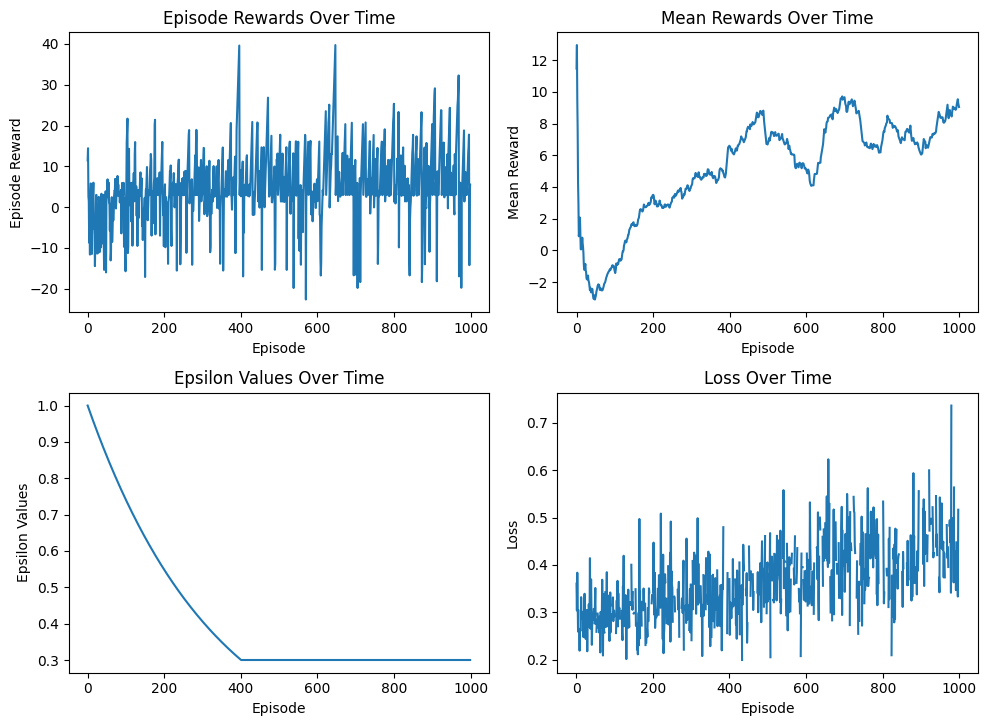

episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
episode reward,▃▂▄▄▄▅▄▄▄▄▄▃▃▄▃▄▆▄▄▅▄▃▃▄▅▃▄█▄▃▅▄▅▆▁▄▃▆▄▃
epsilon,██▆▆▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▅▃▃▂▂▂▂▃ ▄▁▂▄ ▂ ▂▄▃▄ ▇ ▆▇▆ ▆▆ ▆ ▆ █
mean_rewards,▁▂▁▁▁▂▂▂▄▄▄▅▅▅▅▅▆▆▇▇▇█▇▇▇▆▆▆▅██▇▆▇▇▆▆▇██
episode,1000
episode reward,5.52573
epsilon,0.3
loss,0.49454
mean_rewards,9.04223


In [8]:
agent.train(
    train_pairs=train_pairs,
    gamma=GAMMA,
    max_episodes=MAX_EPISODES,
    dnn_update_frequency=DNN_UPD,
    dnn_sync_frequency=DNN_SYNC
)
wandb.finish()

In [ ]:
wandb.finish()